<a href="https://colab.research.google.com/github/georgezoto/Coding-in-TensorFlow/blob/master/Friends-The-One-With-Deep-Learning/Friends_The_One_With_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Friends: The One With Deep Learning

**Meetup event, come and join us 😀**  
https://www.meetup.com/Deep-Learning-Adventures/events/272091447

**Deep Learning YouTube recordings, feel free to share and subscribe 😀**  
https://bit.ly/deep-learning-tf  
https://bit.ly/deep-learning-tf-coding  

- Coding session on real world data - Sequence models/Recurrent Neural Networks/Transformer models

- **Step 1 😀**  
Learn more about the award winning TV show Friends, an American sitcom television series, created by David Crane and Marta Kauffman, which aired on NBC from September 22, 1994, to May 6, 2004, lasting ten seasons. With an ensemble cast starring Jennifer Aniston, Courteney Cox, Lisa Kudrow, Matt LeBlanc, Matthew Perry and David Schwimmer, the show revolves around six friends in their 20s and 30s who live in Manhattan, New York City.
https://en.wikipedia.org/wiki/Friends

- **Step 2 😀**  
Read more about the EmotionX 2019 challenge and its shared task of SocialNLP 2019 where participants are challenged to predict the emotions induced by dialogue utterances by classifying each utterance into one of seven label candidates: neutral, joy, sadness, fear, anger, surprise and disgust.
https://sites.google.com/view/emotionx2019/home
https://sites.google.com/view/emotionx2019/datasets

- **Step 3 😀**  
Learn more about EmotionLines, the first dataset with emotions labeling on all utterances in each dialogue only based on their textual content. Dialogues in EmotionLines are collected from Friends TV scripts and private Facebook messenger dialogues. Then one of seven emotions, six Ekman’s basic emotions plus the neutral emotion, is labeled on each utterance by 5 Amazon MTurkers. A total of 29,245 utterances from 2,000 dialogues are labeled in EmotionLines.http://doraemon.iis.sinica.edu.tw/emotionlines/index.html

- **Step 4 😀**  
Read the EmotionLines Paper: An Emotion Corpus of Multi-Party Conversations
https://arxiv.org/pdf/1802.08379.pdf

- **Step 5 😀**  
Download and explore the Friends dataset which contains a training, validation and test set
http://doraemon.iis.sinica.edu.tw/emotionlines/download.html

- You can also read more about the SocialNLP 2018 EmotionX Challenge Overview: Recognizing Emotions in Dialogues  
https://www.aclweb.org/anthology/W18-3505.pdf

- **Step 6 😀**  
Build your NLP classification model using deep learning or any other ML or non-AI approach. Feel free to use any environment you feel comfortable: personal computer, Colab, Kaggle, GCP/AWS virtual machine. Feel free to use any model you are comfortable with and spend some time in hyper-paramater tuning to make sure you are not overfitting your training data while optimizing for train/validation accuracy and loss. We recommend you use TensorFlow so it's easier to comment on each other's code but you don't have to.

- **Step 7 😀**  
Have fun 🎉 and share your journey, findings, lessons learned, success or failures with us and be ready to take a deeper dive in our code. For us, it's the effort that counts and not the final result. Most importantly you should enjoy exploring this interesting dataset and learn something new 😀

**Source:**  
https://en.wikipedia.org/wiki/Friends  
https://www.kaggle.com/rezaghari/friends-series-dataset  
http://doraemon.iis.sinica.edu.tw/emotionlines/index.html  
https://sites.google.com/view/emotionx2019/home  
https://www.aclweb.org/anthology/W18-3505.pdf  
https://affective-meld.github.io  
https://github.com/declare-lab/MELD  


![alt Friends: The One With Deep Learning](https://secure.meetupstatic.com/photos/event/d/b/2/6/highres_491456102.jpeg)

In [2]:
#Data pre-processing
import os
import zipfile
import pickle

#Plot images
import matplotlib.pyplot as plt

#TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)

#Inspiration from David's code 
#TensorFlow addon to calculate F1 metric
import tensorflow_addons as tfa
#classification_report is a great summary report on performance of our model on the test dataset
from sklearn.metrics import classification_report

#Random seed for reproduciable results
import random
seed = 51
tf.random.set_seed(seed)
random.seed(seed)

2.3.0
0.8.0


### Plot training and validation accuracy and loss

In [76]:
def plot_training_validation_accuracy_loss(version, history_file_path, figsize=(20, 14)):
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', figsize=figsize)

  #Number of time series
  num_time_series = len(version)

  for i in range(num_time_series):
    with open(history_file_path[i], 'rb') as handle:
      history = pickle.load(handle)
    
    if i == 0:
      style = '-' #, linewidth=2, markersize=12
    elif i == 1:
      style = '--'
    elif i == 2:
      style = '+-'
    elif i == 3:
      style = 'o-'

    ax1.plot(history['accuracy'], style, label=version[i] + ' Training accuracy')
    ax1.plot(history['val_accuracy'], style, label=version[i] + ' Validation accuracy')  
    ax2.plot(history['loss'], style, label=version[i] + ' Training loss')
    ax2.plot(history['val_loss'], style, label=version[i] + ' Validation loss')
    ax3.plot(history['f1'], style, label=version[i] + ' Training f1_score')
    ax3.plot(history['val_f1'], style, label=version[i] + ' Validation f1_score')
    
  ax1.legend(loc='best')
  ax1.set_title('Training and validation accuracy')
  ax2.legend(loc='best')
  ax2.set_title('Training and Validation loss')
  ax3.legend(loc='best')
  ax3.set_title('Training and validation f1_score')
  
  plt.xlabel('Epochs')
  plt.show()

In [4]:
import urllib.request
#'https://goo.gl/rzfLf5'
EmotionLines_Friends_Dataset = 'https://drive.google.com/u/0/uc?id=1Koxs2pVSmmO_-LWDGx3uUODVHY1yNrTM&export=download'
urllib.request.urlretrieve(EmotionLines_Friends_Dataset, '/tmp/EmotionLines_Friends_Dataset.tar.gz');

In [5]:
#!wget --no-check-certificate \
#'https://drive.google.com/u/0/uc?id=1Koxs2pVSmmO_-LWDGx3uUODVHY1yNrTM&export=download'\
# -O /tmp/EmotionLines_Friends_Dataset.tar.gz

In [6]:
import tarfile
tar = tarfile.open('/tmp/EmotionLines_Friends_Dataset.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [7]:
import json
friends_train_path = '/content/EmotionLines/Friends/friends_train.json'
friends_validation_path = '/content/EmotionLines/Friends/friends_dev.json'
friends_test_path = '/content/EmotionLines/Friends/friends_test.json'

with open(friends_train_path, 'r') as f:
    friends_train = json.load(f)

with open(friends_validation_path, 'r') as f:
    friends_validation = json.load(f)

with open(friends_test_path, 'r') as f:
    friends_test = json.load(f)    

In [8]:
type(friends_train)

list

In [9]:
print(len(friends_train), len(friends_validation), len(friends_test))

720 80 200


In [10]:
friends_train[0][:3]

[{'annotation': '4100000',
  'emotion': 'neutral',
  'speaker': 'Chandler',
  'utterance': 'also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.'},
 {'annotation': '5000000',
  'emotion': 'neutral',
  'speaker': 'The Interviewer',
  'utterance': 'You must\x92ve had your hands full.'},
 {'annotation': '5000000',
  'emotion': 'neutral',
  'speaker': 'Chandler',
  'utterance': 'That I did. That I did.'}]

In [11]:
len(friends_train[0])

23

In [13]:
friends_train[0][:3]

[{'annotation': '4100000',
  'emotion': 'neutral',
  'speaker': 'Chandler',
  'utterance': 'also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.'},
 {'annotation': '5000000',
  'emotion': 'neutral',
  'speaker': 'The Interviewer',
  'utterance': 'You must\x92ve had your hands full.'},
 {'annotation': '5000000',
  'emotion': 'neutral',
  'speaker': 'Chandler',
  'utterance': 'That I did. That I did.'}]

### Inspiration from David's choice to combine speaker with the utterance
https://github.com/dcpatton/NLP/blob/master/Friends_NLP.ipynb

In [80]:
#training dataset
train_utterance = []
train_emotion = []
train_speaker = []

for dialogue in friends_train:
  for line in dialogue:
    train_utterance.append(line['speaker'] +' says: '+ line['utterance'].replace('\x92', '\''))

    #Neutral, Joy, Sadness, Fear, Anger, Surprise, Disgust, Non-Neutral
    e = line['emotion']

    int_emotion = 0
    if e == 'neutral':
      int_emotion = 0
    elif e == 'joy':
      int_emotion = 1
    elif e == 'sadness':
      int_emotion = 2
    elif e == 'fear':
      int_emotion = 3
    elif e == 'anger':
      int_emotion = 4
    elif e == 'surprise':
      int_emotion = 5
    elif e == 'disgust':
      int_emotion = 6
    elif e == 'non-neutral':
      int_emotion = 7

    train_emotion.append(int_emotion)
    train_speaker.append(line['speaker'])

#validation dataset
validation_utterance = []
validation_emotion = []
validation_speaker = []

for dialogue in friends_validation:
  for line in dialogue:
    validation_utterance.append(line['speaker'] +' says: '+ line['utterance'].replace('\x92', '\''))

    #Neutral, Joy, Sadness, Fear, Anger, Surprise, Disgust, Non-Neutral
    e = line['emotion']

    int_emotion = 0
    if e == 'neutral':
      int_emotion = 0
    elif e == 'joy':
      int_emotion = 1
    elif e == 'sadness':
      int_emotion = 2
    elif e == 'fear':
      int_emotion = 3
    elif e == 'anger':
      int_emotion = 4
    elif e == 'surprise':
      int_emotion = 5
    elif e == 'disgust':
      int_emotion = 6
    elif e == 'non-neutral':
      int_emotion = 7

    validation_emotion.append(int_emotion)
    validation_speaker.append(line['speaker'])

#test dataset
test_utterance = []
test_emotion = []
test_speaker = []

for dialogue in friends_test:
  for line in dialogue:
    test_utterance.append(line['speaker'] +' says: '+ line['utterance'].replace('\x92', '\''))

    #Neutral, Joy, Sadness, Fear, Anger, Surprise, Disgust, Non-Neutral
    e = line['emotion']

    int_emotion = 0
    if e == 'neutral':
      int_emotion = 0
    elif e == 'joy':
      int_emotion = 1
    elif e == 'sadness':
      int_emotion = 2
    elif e == 'fear':
      int_emotion = 3
    elif e == 'anger':
      int_emotion = 4
    elif e == 'surprise':
      int_emotion = 5
    elif e == 'disgust':
      int_emotion = 6
    elif e == 'non-neutral':
      int_emotion = 7

    test_emotion.append(int_emotion)
    test_speaker.append(line['speaker'])   

In [81]:
print(len(train_utterance), len(validation_utterance), len(test_utterance))

10561 1178 2764


In [26]:
for s, u, e in zip(train_utterance[:3], train_utterance[:3], train_emotion[:3]):
  print(s, u, e)

Chandler says: also I was the point person on my company's transition from the KL-5 to GR-6 system. Chandler says: also I was the point person on my company's transition from the KL-5 to GR-6 system. 0
The Interviewer says: You must've had your hands full. The Interviewer says: You must've had your hands full. 0
Chandler says: That I did. That I did. Chandler says: That I did. That I did. 0


In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [28]:
num_classes = 8
#The total of EIGHT labels are Neutral, Joy, Sadness, Fear, Anger, Surprise, Disgust and Non-Neutral

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
#training_size = 20000

In [29]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_utterance)

In [30]:
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'says': 2,
 'i': 3,
 'you': 4,
 'the': 5,
 'joey': 6,
 'ross': 7,
 'to': 8,
 'rachel': 9,
 'a': 10,
 'phoebe': 11,
 'chandler': 12,
 'monica': 13,
 'and': 14,
 'oh': 15,
 'it': 16,
 'that': 17,
 'no': 18,
 'what': 19,
 "i'm": 20,
 'is': 21,
 'this': 22,
 'me': 23,
 'okay': 24,
 'so': 25,
 'yeah': 26,
 'just': 27,
 'of': 28,
 'my': 29,
 'in': 30,
 'have': 31,
 'we': 32,
 'hey': 33,
 "it's": 34,
 'do': 35,
 "don't": 36,
 'well': 37,
 'all': 38,
 'know': 39,
 'on': 40,
 'not': 41,
 'are': 42,
 'for': 43,
 'right': 44,
 'was': 45,
 'with': 46,
 'but': 47,
 'be': 48,
 "that's": 49,
 'go': 50,
 'your': 51,
 'like': 52,
 'gonna': 53,
 'get': 54,
 'here': 55,
 'out': 56,
 'really': 57,
 "you're": 58,
 'uh': 59,
 'can': 60,
 "y'know": 61,
 'about': 62,
 'up': 63,
 'he': 64,
 'think': 65,
 'look': 66,
 'there': 67,
 'how': 68,
 'now': 69,
 'her': 70,
 'one': 71,
 'if': 72,
 'at': 73,
 'got': 74,
 'mean': 75,
 'see': 76,
 'come': 77,
 'god': 78,
 'why': 79,
 'him': 80,
 'did': 81,
 

In [31]:
train_utterance_sequences = tokenizer.texts_to_sequences(train_utterance)
train_utterance_padded = pad_sequences(train_utterance_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [32]:
validation_utterance_sequences = tokenizer.texts_to_sequences(validation_utterance)
validation_utterance_padded = pad_sequences(validation_utterance_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [82]:
test_utterance_sequences = tokenizer.texts_to_sequences(test_utterance)
test_utterance_padded = pad_sequences(test_utterance_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [33]:
train_utterance[:3]

["Chandler says: also I was the point person on my company's transition from the KL-5 to GR-6 system.",
 "The Interviewer says: You must've had your hands full.",
 'Chandler says: That I did. That I did.']

In [34]:
train_utterance_sequences[:3]

[[12, 2, 429, 3, 45, 5, 803, 463, 40, 29, 1, 1, 129, 5, 1, 1, 8, 1, 967, 968],
 [5, 746, 2, 4, 881, 108, 51, 747, 882],
 [12, 2, 17, 3, 81, 17, 3, 81]]

In [35]:
train_utterance_padded[:3]

array([[ 12,   2, 429,   3,  45,   5, 803, 463,  40,  29,   1,   1, 129,
          5,   1,   1,   8,   1, 967, 968,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  5, 746,   2,   4, 881, 108,  51, 747, 882,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,

In [36]:
train_emotion[:3]

[0, 0, 0]

# v1 - Emotion Detection with our own Embedding + Bi LSTM(32) - 0.03M parameters 72% training, 40% validation accuracy

### Model Definition

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 200       
Total params: 30,304
Trainable params: 30,304
Non-trainable params: 0
_________________________________________________________________


In [59]:
f1_score = tfa.metrics.F1Score(num_classes, average='micro', name='f1')   # this is the competition metric
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),    # default learning rate
#              loss=tfa.losses.SigmoidFocalCrossEntropy(), 
#              metrics=[f1_score])

In [60]:
checkpoint_filepath = 'Friends-The-One-With-Deep-Learning-v1.h5'

my_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=1, 
                                        save_weights_only=True, monitor='val_loss', 
                                        mode='auto', save_best_only=True)

#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto', restore_best_weights=False)

In [84]:
import numpy as np

train_utterance_padded = np.array(train_utterance_padded)
train_emotion = np.array(train_emotion)
validation_utterance_padded = np.array(validation_utterance_padded)
validation_emotion = np.array(validation_emotion)
test_utterance_padded = np.array(test_utterance_padded)
test_emotion = np.array(test_emotion)

In [62]:
train_utterance_padded[:3]

array([[ 12,   2, 429,   3,  45,   5, 803, 463,  40,  29,   1,   1, 129,
          5,   1,   1,   8,   1, 967, 968,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  5, 746,   2,   4, 881, 108,  51, 747, 882,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,

In [63]:
train_emotion[:3]

array([0, 0, 0])

### Compile and Fit Model

In [64]:
num_epochs = 50

history = model.fit(train_utterance_padded, train_emotion, epochs=num_epochs,\
                    validation_data=(validation_utterance_padded, validation_emotion),\
                    verbose=1, callbacks=[my_callback])

Epoch 1/50
330/331 [============================>.] - ETA: 0s - loss: 1.3070 - accuracy: 0.5420 - f1: 0.1887
Epoch 00001: val_loss improved from inf to 1.58132, saving model to Friends-The-One-With-Deep-Learning-v1.h5
331/331 [==============================] - 5s 15ms/step - loss: 1.3069 - accuracy: 0.5421 - f1: 0.1887 - val_loss: 1.5813 - val_accuracy: 0.4457 - val_f1: 0.1898
Epoch 2/50
329/331 [============================>.] - ETA: 0s - loss: 1.2793 - accuracy: 0.5509 - f1: 0.1887
Epoch 00002: val_loss did not improve from 1.58132
331/331 [==============================] - 4s 13ms/step - loss: 1.2800 - accuracy: 0.5504 - f1: 0.1887 - val_loss: 1.5845 - val_accuracy: 0.4457 - val_f1: 0.1898
Epoch 3/50
331/331 [==============================] - ETA: 0s - loss: 1.2710 - accuracy: 0.5489 - f1: 0.1887
Epoch 00003: val_loss did not improve from 1.58132
331/331 [==============================] - 4s 13ms/step - loss: 1.2710 - accuracy: 0.5489 - f1: 0.1887 - val_loss: 1.5843 - val_accuracy: 

### Store the history object to disk 
So we can plot anytime without retraining this model

https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict  
https://stackoverflow.com/questions/23582489/python-pickle-protocol-choice

In [66]:
#Write history to disk
with open('Friends-The-One-With-Deep-Learning-v1.history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

#Read history from disk
#with open('Cassava-Disease-Classification-v1.history.pickle', 'rb') as handle:
#    history = pickle.load(handle)

### Plot traning and validation accuracy and loss

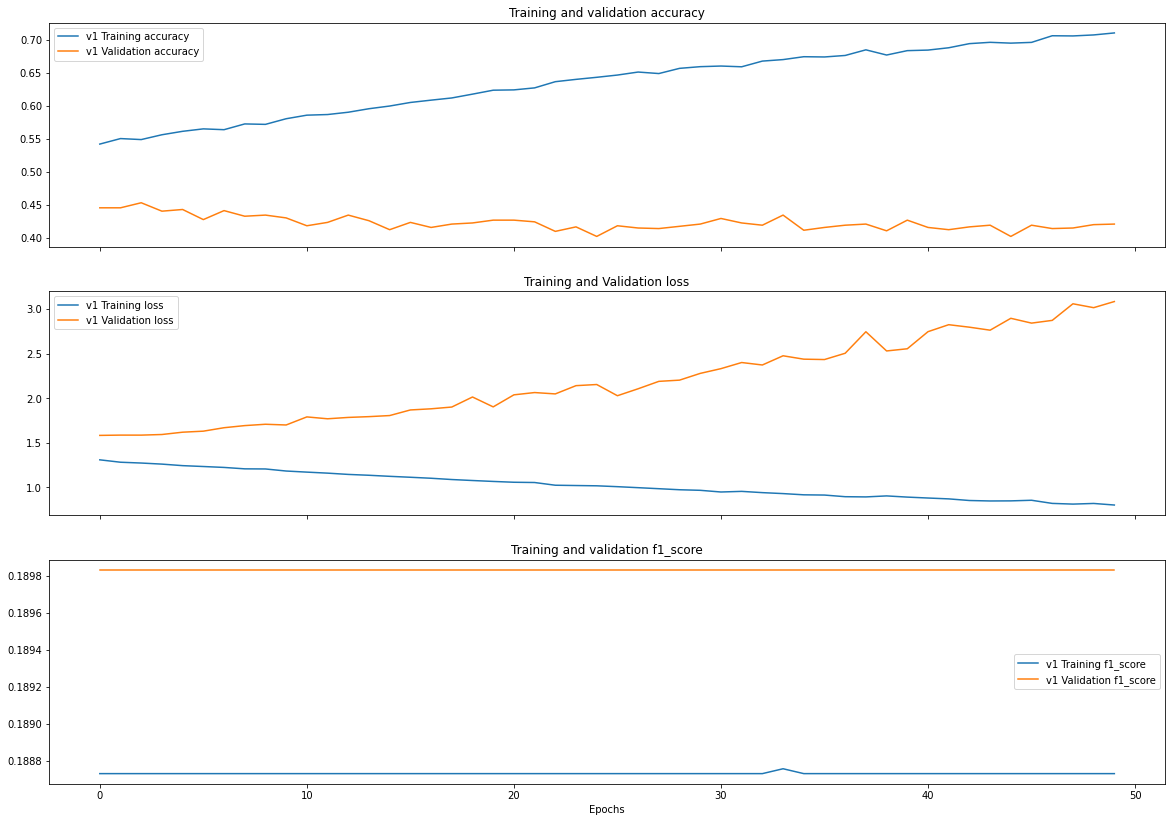

In [77]:
version = ['v1']
history_file_path = ['Friends-The-One-With-Deep-Learning-v1.history.pickle']
plot_training_validation_accuracy_loss(version, history_file_path)

### Evaluate model on the test set

In [85]:
model.evaluate(test_utterance_padded, test_emotion, verbose=1)

87/87 [==============================] - 1s 7ms/step - loss: 2.5556 - accuracy: 0.4479 - f1: 0.1875


[2.5555858612060547, 0.4479016065597534, 0.187519833445549]

In [86]:
y_pred = model.predict(test_utterance_padded)
y_pred = y_pred.argmax(axis=1)

In [90]:
print(classification_report(test_emotion, y_pred)) #, target_names=labelEncoder.classes_

              precision    recall  f1-score   support

           0       0.56      0.69      0.62      1287
           1       0.35      0.35      0.35       304
           2       0.18      0.22      0.20        85
           3       0.00      0.00      0.00        32
           4       0.20      0.07      0.10       161
           5       0.38      0.34      0.36       286
           6       0.07      0.03      0.04        68
           7       0.26      0.20      0.23       541

    accuracy                           0.45      2764
   macro avg       0.25      0.24      0.24      2764
weighted avg       0.41      0.45      0.42      2764



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# v2 - Emotion Detection with our own Embedding + Bi LSTM(64), Bi LSTM(32) - 0.1M parameters 71% training, 39% validation accuracy

### Model Definition

In [91]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120, 128)          41472     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                

### Compile and Fit Model

In [92]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

In [93]:
checkpoint_filepath = 'Friends-The-One-With-Deep-Learning-v2.h5'
my_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=1, 
                                        save_weights_only=True, monitor='val_loss', 
                                        mode='auto', save_best_only=True)

In [94]:
num_epochs = 50

history = model.fit(train_utterance_padded, train_emotion, epochs=num_epochs,\
                    validation_data=(validation_utterance_padded, validation_emotion),\
                    verbose=1, callbacks=[my_callback])

Epoch 1/50
330/331 [============================>.] - ETA: 0s - loss: 1.6367 - accuracy: 0.4479 - f1: 0.1885
Epoch 00001: val_loss improved from inf to 1.69181, saving model to Friends-The-One-With-Deep-Learning-v2.h5
331/331 [==============================] - 9s 27ms/step - loss: 1.6366 - accuracy: 0.4480 - f1: 0.1885 - val_loss: 1.6918 - val_accuracy: 0.4278 - val_f1: 0.1898
Epoch 2/50
330/331 [============================>.] - ETA: 0s - loss: 1.5458 - accuracy: 0.4643 - f1: 0.1887
Epoch 00002: val_loss improved from 1.69181 to 1.61537, saving model to Friends-The-One-With-Deep-Learning-v2.h5
331/331 [==============================] - 8s 23ms/step - loss: 1.5459 - accuracy: 0.4643 - f1: 0.1887 - val_loss: 1.6154 - val_accuracy: 0.4270 - val_f1: 0.1898
Epoch 3/50
329/331 [============================>.] - ETA: 0s - loss: 1.4824 - accuracy: 0.4882 - f1: 0.1887
Epoch 00003: val_loss improved from 1.61537 to 1.58996, saving model to Friends-The-One-With-Deep-Learning-v2.h5
331/331 [=====

### Store the history object to disk 
So we can plot anytime without retraining this model

In [95]:
#Write history to disk
with open('Friends-The-One-With-Deep-Learning-v2.history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Plot traning and validation accuracy and loss

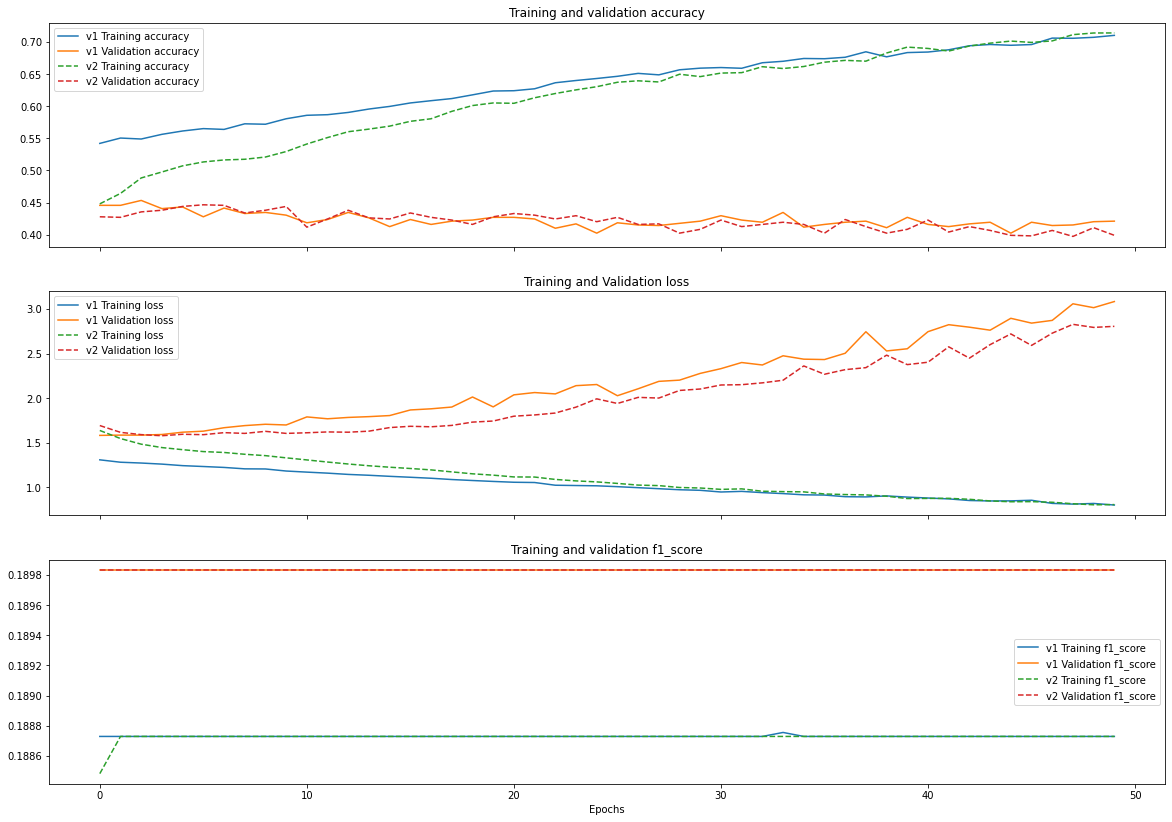

In [96]:
version = ['v1', 'v2']
history_file_path = ['Friends-The-One-With-Deep-Learning-v1.history.pickle', 
                     'Friends-The-One-With-Deep-Learning-v2.history.pickle']

plot_training_validation_accuracy_loss(version, history_file_path)

### Evaluate model on the test set

In [97]:
model.evaluate(test_utterance_padded, test_emotion, verbose=1)

87/87 [==============================] - 1s 10ms/step - loss: 2.3835 - accuracy: 0.4378 - f1: 0.1875


[2.3834879398345947, 0.43777135014533997, 0.187519833445549]

In [98]:
y_pred = model.predict(test_utterance_padded)
y_pred = y_pred.argmax(axis=1)

In [99]:
print(classification_report(test_emotion, y_pred)) #, target_names=labelEncoder.classes_

              precision    recall  f1-score   support

           0       0.56      0.66      0.60      1287
           1       0.33      0.32      0.33       304
           2       0.16      0.14      0.15        85
           3       0.00      0.00      0.00        32
           4       0.16      0.07      0.10       161
           5       0.39      0.39      0.39       286
           6       0.00      0.00      0.00        68
           7       0.26      0.24      0.25       541

    accuracy                           0.44      2764
   macro avg       0.23      0.23      0.23      2764
weighted avg       0.40      0.44      0.42      2764



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# v3 - Emotion Detection  with our own Embedding + 1D Convolutional Layer - 0.03M parameters 86% training, 39% validation accuracy

### Model Definition

In [100]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                3096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 200       
Total params: 29,664
Trainable params: 29,664
Non-trainable params: 0
__________________________________________________

### Compile and Fit Model

In [101]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

In [102]:
checkpoint_filepath = 'Friends-The-One-With-Deep-Learning-v3.h5'
my_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=1, 
                                        save_weights_only=True, monitor='val_loss', 
                                        mode='auto', save_best_only=True)

In [103]:
num_epochs = 50

history = model.fit(train_utterance_padded, train_emotion, epochs=num_epochs,\
                    validation_data=(validation_utterance_padded, validation_emotion),\
                    verbose=1, callbacks=[my_callback])

Epoch 1/50
331/331 [==============================] - ETA: 0s - loss: 1.6633 - accuracy: 0.4388 - f1: 0.1885
Epoch 00001: val_loss improved from inf to 1.65733, saving model to Friends-The-One-With-Deep-Learning-v3.h5
331/331 [==============================] - 2s 5ms/step - loss: 1.6633 - accuracy: 0.4388 - f1: 0.1885 - val_loss: 1.6573 - val_accuracy: 0.4219 - val_f1: 0.1898
Epoch 2/50
319/331 [===========================>..] - ETA: 0s - loss: 1.5237 - accuracy: 0.4749 - f1: 0.1887
Epoch 00002: val_loss improved from 1.65733 to 1.58613, saving model to Friends-The-One-With-Deep-Learning-v3.h5
331/331 [==============================] - 1s 4ms/step - loss: 1.5225 - accuracy: 0.4761 - f1: 0.1887 - val_loss: 1.5861 - val_accuracy: 0.4508 - val_f1: 0.1898
Epoch 3/50
330/331 [============================>.] - ETA: 0s - loss: 1.4443 - accuracy: 0.4991 - f1: 0.1887
Epoch 00003: val_loss improved from 1.58613 to 1.56645, saving model to Friends-The-One-With-Deep-Learning-v3.h5
331/331 [=======

### Store the history object to disk 
So we can plot anytime without retraining this model

In [104]:
#Write history to disk
with open('Friends-The-One-With-Deep-Learning-v3.history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Plot traning and validation accuracy and loss

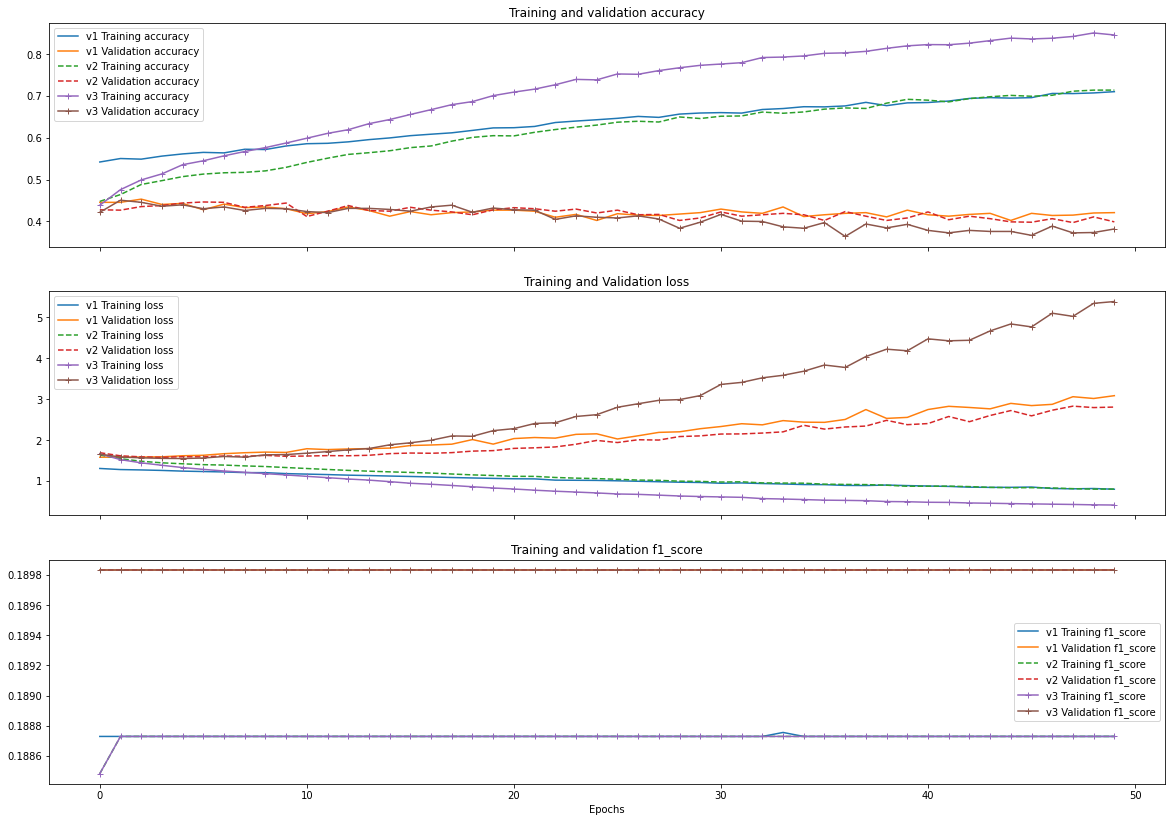

In [105]:
version = ['v1', 'v2', 'v3']
history_file_path = ['Friends-The-One-With-Deep-Learning-v1.history.pickle', 
                     'Friends-The-One-With-Deep-Learning-v2.history.pickle',
                     'Friends-The-One-With-Deep-Learning-v3.history.pickle']

plot_training_validation_accuracy_loss(version, history_file_path)

### Evaluate model on the test set

In [106]:
model.evaluate(test_utterance_padded, test_emotion, verbose=1)

87/87 [==============================] - 0s 3ms/step - loss: 4.7147 - accuracy: 0.3965 - f1: 0.1875


[4.71474027633667, 0.3965267837047577, 0.187519833445549]

In [107]:
y_pred = model.predict(test_utterance_padded)
y_pred = y_pred.argmax(axis=1)

In [108]:
print(classification_report(test_emotion, y_pred)) #, target_names=labelEncoder.classes_

              precision    recall  f1-score   support

           0       0.56      0.57      0.56      1287
           1       0.34      0.23      0.28       304
           2       0.15      0.15      0.15        85
           3       0.20      0.03      0.05        32
           4       0.12      0.09      0.10       161
           5       0.38      0.41      0.39       286
           6       0.06      0.03      0.04        68
           7       0.21      0.27      0.24       541

    accuracy                           0.40      2764
   macro avg       0.25      0.22      0.23      2764
weighted avg       0.39      0.40      0.39      2764

